In [11]:
# import Serial libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from cartpole_lib_python import *
import odrive

In [2]:
init_odrive()
init_odrive()

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
odrive initialized
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
odrive initialized


In [3]:
odrv = get_odrive()
odrive.utils.dump_errors(odrv)

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: 

none


In [78]:
print(get_state())

[0.018446280991735536, 1.5508545765523838, -2.072381977682968e-08, -0.005192321324630406]


In [79]:
def busy_sleep1(duration, loop_start, get_now=time.time):
    # now = time.perf_counter()
    now = get_now()

    end = duration + loop_start

    while now < end:
        # now = time.perf_counter()
        now = get_now()
# def busy_sleep(duration, loop_start = None, get_now=time.time):
#     now = get_now()

#     if loop_start is None:
#         end = now + duration
#     else: 
#         end = loop_start + duration

#     while now < end:
#         now = get_now()

In [80]:
control_frequency = 100 # Hz
control_period = 1/control_frequency # time.time() does not track this accurately. Use time.perf_counter()
T = 10 # seconds
N = int(T*control_frequency) # number of control steps
print("N: ", N)

x_sin = np.zeros((N,2)) # pos, vel
x_sin[0,1] = 0
for i in range(N):
    x_sin[i,0] = np.sin(i/N * 4*np.pi)/4
    if i > 0:
        x_sin[i,1] = (x_sin[i,0] - x_sin[i-1,0])/control_period


measurements = np.zeros((N,2)) # initialize data array
states = np.zeros((N,4)) # initialize data array
errs = np.zeros((N,2))
states_lpf = np.zeros((N,4)) # initialize data array
states_kf = np.zeros((N,4)) # initialize data array
controls = np.zeros((N,1)).astype(float) # initialize control array
control_input = np.zeros((N,2)).astype(float) # just for latency testing/debugging 
loop_time = []

k_matrix = np.array([-5.78107, -31.63476, -5.54811, -6.42603])

control_clamp = 0.1
mid_point = 0.0184462809917
down = 5.6695929920
# xg = np.array([mid_point, down+np.pi, 0, 0])
xg = np.array([mid_point, 1.552388557340268, 0, 0])

prev_x_vel = 0
prev_theta_vel = 0
first = True

control_lpf = 0


# Kalman filter

A = np.array([
 [1.0,  -0.000236952,  0.01,  -7.89636e-7],
 [0.0,   1.00155,      0.0,    0.0100052],
 [0.0,  -0.0474026,    1.0,   -0.000236952],
 [0.0,   0.310128,     0.0,    1.00155]
])

B = np.array([
 [ 0.00010488559235509306],
 [-0.00022351674743717424],
 [ 0.020978882982939165],
 [-0.04471489366429143]
])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
# H = np.eye(4)

# meas_noise_cov = np.diag([.1,.1])
# process_noise_cov = np.diag([1,.05,100,100]) # position, angle, linear velocity, angular velocity

meas_noise_cov = np.diag([.1,.1]) # most recent
process_noise_cov = np.diag([1,1,50,50]) # position, angle, linear velocity, angular velocity

# meas_noise_cov = np.diag([.1, .1])
# process_noise_cov = np.diag([1,1,1,1]) # position, angle, linear velocity, angular velocity

# meas_noise_cov = np.diag([1,1,10000,10000])
# process_noise_cov = np.diag([1,1,1,1]) # position, angle, linear velocity, angular velocity
nx = process_noise_cov.shape[0]
def kf_update(x_meas, x_pred_prev, est_cov_prev):
    Kn = est_cov_prev@H.T @ np.linalg.inv(H@est_cov_prev@H.T + meas_noise_cov)
    x = x_pred_prev + Kn @ (x_meas - H@x_pred_prev)
    est_cov = (np.eye(nx) - Kn@H) @ est_cov_prev @ (np.eye(nx) - Kn@H).T + Kn@meas_noise_cov@Kn.T
    return x, est_cov

def kf_predict(state, control, est_cov):
    x_pred = A@state + B@control
    est_cov_pred = A@est_cov@A.T + process_noise_cov
    return x_pred, est_cov_pred



# Initialize Kalman filter variables
# First state estimate
meas = get_measurement() - xg[:2]
# meas = [0,0]
# meas = get_state() - xg
x = np.array([meas[0], meas[1], 0, 0])
x_pred_prev = x

# Estimation covariance
est_cov = np.eye(4)*20
est_cov_prev = est_cov

est_covs = np.zeros((N,4,4)).astype(float)
est_covs[0] = est_cov

for i in range(N):
    time_start = time.perf_counter()

    state = get_state()
    states_lpf[i,:] = state
    
    measurement = get_measurement() - xg[:2]
    measurements[i,:] = measurement
    if i > 0:
        x, est_cov = kf_update(measurement, x_pred_prev, est_cov_prev)
        x[3] /= 2
        est_covs[i] = est_cov
    states_kf[i,:] = x
    states[i,:] = x
    # control = -k_matrix @ (states[i,:] - xg).T * 0.01
    control = -k_matrix @ states[i,:].T * 0.3
    # err = (np.hstack([states_lpf[i,0], states_lpf[i,2]]) - x_sin[i,:] - np.array([xg[0], xg[2]]))
    # errs[i] = err
    # control = k_matrix_sin @ err * .02
    

    # mult_control = 1
    # control = (mult_control * control) + ((1-mult_control) * control_lpf)
    # control_lpf = control

    if control > control_clamp:
        control = control_clamp
    elif control < -control_clamp:
        control = -control_clamp
    
    # control = x_sin[i,0]/2
    controls[i] = control
    
    
    x_pred_prev, est_cov_prev = kf_predict(x, [control], est_cov)
    
    # control = 0
    
    
    command_linear_torque(-control)
    

    # time_sleep = control_period - (time.time() - time_start)
    # if time_sleep < 0:
    #     time_sleep = 0
    # time.sleep(time_sleep)
    # if time_start > time.time():
    #     time_start = time.time()
    busy_sleep1(control_period, time_start)
    # busy_sleep(control_period, loop_start=time_start, get_now=time.perf_counter)
    # busy_sleep(.005)
    loop_time.append(time.perf_counter() - time_start)

command_linear_torque(0)

N:  1000


In [128]:
get_measurement() - xg[:2]

array([ 0.06218182, -0.01227185])

In [38]:
command_linear_torque(0)

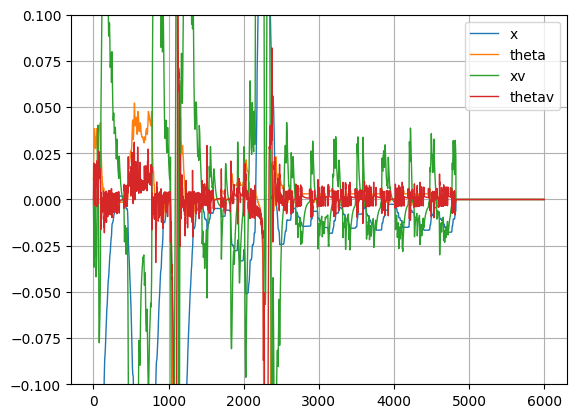

In [6]:
theta_vels = np.zeros(N)
linear_vels = np.zeros(N)
theta_vels[0] = 0
linear_vels[0] = 0
for i in range(1,N):
    theta_vels[i] = (measurements[i,1] - measurements[i-1,1]) / control_period /10
    linear_vels[i] = (measurements[i,0] - measurements[i-1,0]) / control_period /10
    # theta_vels[i] = (measurements[i,1] - measurements[i-1,1])
    # linear_vels[i] = (measurements[i,0] - measurements[i-1,0])

# plt.plot(states, '-', linewidth=3)
plt.plot(states, '-', linewidth=1)
# plt.plot(states[:,0], linewidth=1)
# plt.plot(states[:,2], linewidth=1)
# plt.plot(states_lpf-xg, linewidth=.8)

# plt.plot(measurements)
# plt.plot(linear_vels, '--')
# plt.plot(theta_vels, '--')

# plt.plot(controls)

plt.ylim([-.1,.1])
# plt.ylim([-.2,.2])
# plt.ylim([-.4,.4])
# plt.ylim([-2,2])
# plt.ylim([-4,4])
# plt.legend(['x', 'xv'])
plt.legend(['x', 'theta', 'xv', 'thetav'])
# plt.legend(['x', 'theta', 'xv', 'thetav', 'thetameas'])
# plt.legend(['x', 'theta', 'xv', 'thetav', 'x', 'theta', 'xv', 'thetav'])
# plt.legend(['x', 'theta', 'xv', 'thetav', 'linear_vels', 'theta_vels'])
# plt.legend(['x', 'theta', 'xv', 'thetav', 'theta_vels'])
# plt.legend(['x', 'theta', 'linear_vels', 'theta_vels'])
plt.grid()
plt.show()

# plt.plot(states_kf, linewidth=1)
# plt.legend(['x', 'theta', 'xv', 'thetav'])


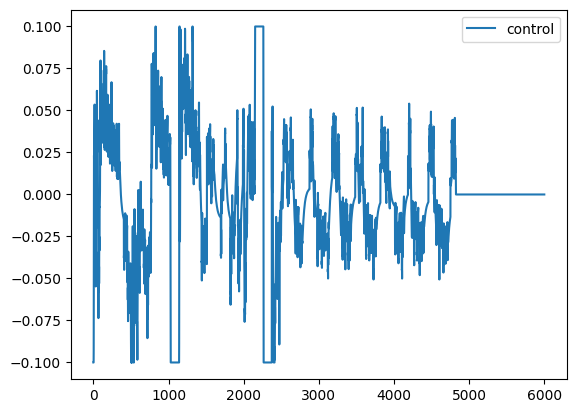

In [7]:
plt.plot(controls, label = "control")
# plt.plot(errs)
# plt.plot(np.vstack([states_lpf[:,0], states_lpf[:,2]]).T - np.tile(np.array([xg[0], xg[2]]),(len(states_lpf),1)))
# plt.plot(x_sin)
plt.ylim([-control_clamp*1.1, control_clamp*1.1])
# plt.legend(["control", "pos err", "vel err", "traj_x", "traj_vel"])
plt.legend(["control", "x", "vel", "traj_x", "traj_vel"])

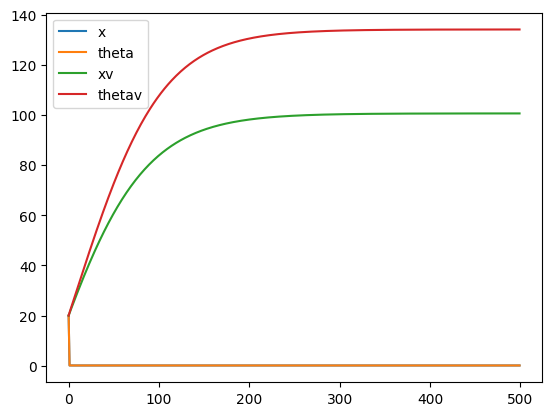

In [892]:
est_cov_diags = [np.diag(est_covs[i]) for i in range(len(est_covs))]
plt.plot(est_cov_diags)
plt.legend(['x', 'theta', 'xv', 'thetav'])

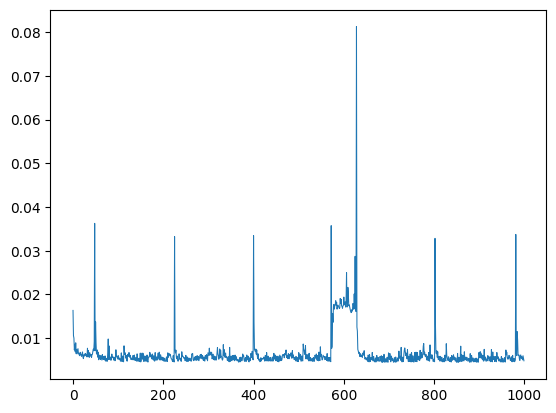

In [23]:
loop_time = np.array(loop_time)
plt.plot(loop_time, linewidth=.75)
# plt.ylim([0,.02])
# plt.ylim([.0099,.0101])